# Assignment 5

Nils Winkler, 24-744-542, nilschristian.winkler@uzh.ch

Andi Vjerdha, 24-745-135,  andivjerdha00@gmail.com

Angus Martin, 24-745-747, angusalexander.martin@uzh.ch

Kornel Ipacs, 24-745-176, kornel.ipacs@uzh.ch

---

## Foreword and overview

The following report aims to show various findings upon construction, to explain why certain implementations have been chosen, and most importantly, to display results of such findings.

The report's structure is aligned to previous assignments in terms of code, starting from relevant function imports and ending with descriptive statistics. At each major step, such as the choice of constraints, a description has been added, including reasoning, previous choices, comparison, and description. Finally, helper functions have been created and used at certain steps, and they can be found within the Appendix of the report.

---

## Indroduction of the strategy 

#TODO at the end



Give high level strategy overview describing the investment strategy created

In [1]:
# Standard library imports
import os
import sys

# Third party imports
import numpy as np
import pandas as pd

# Add the project root directory and src to Python path if not already present
project_root = "C:/Users/nilsw/QPM/qpmwp-course"
src_path = os.path.join(project_root, 'src')

if project_root not in sys.path:
    sys.path.append(project_root)
if src_path not in sys.path:
    sys.path.append(src_path)

## Additional helper functions - Optimization
Throughtout the testing, besides the parameter augmentation of existing strategies, two additional optimization methods have been developed.



| Model             | Construction                                         |
|-------------------|------------------------------------------------------|
| *MaxSharpe*       | the same model developed in Assignment 4             |
| *BlackLittermanMS*| combines the Black-Litterman and Max-Sharpe models   |



---


### High-level summary of **BlackLittermanMS**


It first derives equilibrium returns from cap-weights, updates them with factor-score views via the BlackLitterman Bayesian update, and produces a posterior mean/covariance pair.
Treating the risk-aversion scalar as a "slider", the model re-solves the mean–variance programme along the values the slider can take and lets a one-dimensional optimiser stop where the implied Sharpe ratio peaks.

*Note*: Both functions can be found in Appendix A

---

## Additional helper function - Item builder functions
Throughtout the testing, besides relying on the already developed helper functions, three additional ones have been developed.

| Function                           | Construction                                                                                          |
|------------------------------------|-------------------------------------------------------------------------------------------------------|
| *bibfn_equal_weights*              | Creates an equal-weight benchmark vector for the currently selected assets at each rebalance.        |
| *bibfn_sector_exposure_constraints*| Adds linear constraints that cap the total portfolio weight per sector at predefined limits.
| *bibfn_filter_jkp_factor_scores*| Allows to filter stocks based on jkp_factor_scores, for example we can choose to ignore the stocks with the lowest 5% past 6 months returns or the highest 5% volatility  |

### High-level summary of **bibfn_equal_weights**
At each rebalance, the helper supplies the optimiser with a
benchmark (or “cap-weight”) portfolio that is equally weighted across
the currently selected assets.

### High-level summary of **bibfn_sector_exposure_constraints**
At each rebalance, the optimiser is prevented from allocating more than the defined fraction of total capital to any single sector, preserving portfolio diversification and mitigating cluster risk, based on predefined constraints. It is possible to assign specific sector weights, but we opted for a naive approach without digging deeper into the sector assignments.    |

### High-level summary of **bibfn_filter_jkp_factor_scores**
At each rebalance, allows to filter stocks based on jkp_factor_scores, for example we can choose to ignore the stocks with the lowest 5% past 6 months returns or the highest 5% volatility. This way, it is possible to exclude undesirable stocks, for example low quality or highly volatile ones.

*Note*: All functions can be found in Appendix B


In [10]:
# Local modules imports
from helper_functions import (
    load_data_spi,
    load_pickle,
)
from estimation.covariance import Covariance, CovarianceSpecification

from estimation.expected_return import ExpectedReturn

from optimization.optimization import (
    BlackLitterman, ScoreVariance, MeanVariance , MaxSharpe, BlackLittermanMS                            
)
from backtesting.backtest_item_builder_classes import (
    SelectionItemBuilder,
    OptimizationItemBuilder,
)
from backtesting.backtest_item_builder_functions import (
    # Selection item builder functions
    bibfn_selection_min_volume,
    bibfn_selection_gaps,
    bibfn_selection_ltr,
    bibfn_filter_jkp_factor_scores,
    # Optimization item builder functions
    bibfn_return_series,
    bibfn_scores_ltr,
    bibfn_equal_weights,
    # Constraints item builder functions
    bibfn_budget_constraint,
    bibfn_box_constraints,
    bibfn_size_dependent_upper_bounds,
    bibfn_sector_exposure_constraints
    
)
from backtesting.backtest_data import BacktestData
from backtesting.backtest_service import BacktestService
from backtesting.backtest import Backtest

### Data Loading · Standard Pipeline  

The notebook includes three data sets:

- **Market data**  
  Daily prices, volumes, and fundamentals.

- **JKP factors**  
  The Jegadeesh–Kang–Pollet factor panel used for style scores.

- **Swiss Performance Index (SPI)**  
  Benchmark total-return series for Swiss equities.




In [3]:
# --------------------------------------------------------------------------
# Load data
# - market data (from parquet file)
# - jkp data (from parquet file)
# - swiss performance index, SPI (from csv file)
# --------------------------------------------------------------------------

path_to_data = "C:/Users/nilsw/QPM/qpmwp-course/data/"

# Load market and jkp data from parquet files
market_data = pd.read_parquet(path = f'{path_to_data}market_data.parquet')
jkp_data = pd.read_parquet(path = f'{path_to_data}jkp_data.parquet')

# Instantiate the BacktestData class and set the market data and jkp data as attributes
data = BacktestData()
data.market_data = market_data
data.jkp_data = jkp_data
data.bm_series = load_data_spi(path=path_to_data)

In [4]:
# --------------------------------------------------------------------------
# Create a features dataframe from the jkp_data
# Reset the date index to be consistent with the date index in market_data
# --------------------------------------------------------------------------

market_data_dates = data.market_data.index.get_level_values('date').unique().sort_values()
jkp_data_dates = data.jkp_data.index.get_level_values('date').unique().sort_values()

# Find the nearest future market_data_date for each jkp_data_date
dates_map = {
    date: min(market_data_dates[market_data_dates > date])
    for date in jkp_data_dates
}

# Generates a features dataframe from the jkp_data where you reset
# the date index to b
features = data.jkp_data.reset_index()
features['date'] = features['date'].map(dates_map)
features = features.set_index(['date', 'id'])

In [5]:
# --------------------------------------------------------------------------
# Define training dates and rebalancing dates
# --------------------------------------------------------------------------

train_dates = features.index.get_level_values('date').unique().sort_values()
train_dates = train_dates[train_dates > market_data_dates[0]]

train_dates =train_dates[::3]

rebdates = train_dates[train_dates >= '2015-01-01'].strftime('%Y-%m-%d').tolist()
rebdates = rebdates[0:-1]

Changed rebalance dates to every 3 months instead of every month - note on why we did this?

#Nils: we did this because it makes the backtest faster and the performance isn't that much better with 1 month iirc

In [6]:
# --------------------------------------------------------------------------
# Prepare labels (i.e., ranks of period returns)
# --------------------------------------------------------------------------

# Load return series
return_series = data.get_return_series()

# Compute period returns between the training dates
return_series_agg = (1 + return_series).cumprod().loc[train_dates].pct_change()

# Shift the labels by -1 period (as we want to predict next period return ranks)
return_series_agg_shift = return_series_agg.shift(-1)
# return_series_agg_shift = return_series_agg   # ~~~~~~~~~~~~~~~~~~~~~~~~

# Stack the returns (from wide to long format)
ret = return_series_agg_shift.unstack().reorder_levels([1, 0]).dropna()
ret.name = 'ret'
ret

# Merge the returns and the features dataframes
merged_df = ret.to_frame().join(features, how='inner').sort_index()
merged_df

# Generate the labels (ranks) for the merged data
labels = merged_df.groupby('date')['ret'].rank(method='first', ascending=True).astype(int)
labels = 100 * labels / merged_df.groupby('date').size() # Normalize the ranks to be between 0 and 100
labels = labels.astype(int)  # Convert to integer type
labels

# Insert the labels into the merged data frame
merged_df.insert(0, 'label', labels)
merged_df

# Reset the index of the merged data frame
merged_df.reset_index(inplace=True)
merged_df

# Add the merged data frame to the BacktestData object
data.merged_df = merged_df

C:\Users\nilsw\AppData\Local\Temp\ipykernel_8484\3127731825.py:9: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return_series_agg = (1 + return_series).cumprod().loc[train_dates].pct_change()


### Key portfolio-constraint choices  

| Constraint | Setting | Why it matters |
|------------|---------|----------------|
| **Budget** | ≤ 1.20 (gross exposure) | We changed the budget constraint to allow a *<=* mode, allowing (modest) 20 % leverage, but also allowing a budget of less than 100%. The optimization will dynamically adjust its exposure based on the return and covariance expectations. If the exposure is below 100%, the difference is implicitly held in cash. This can improve Sharpe ratio dramatically, because it reduces volatility. 
| **Box limits** | 0 ≤ wᵢ ≤ 0.10 | Banning short sales and caps any single position at 10 % of Net Asset Value(NAV), aligning with typical UCITS/ other typical fund regulations . |
| **Size-dependent caps** | 2 % for small-caps (< CHF 300 m), 5 % for mid-caps (< CHF 1 bn), 10 % for large-caps | Scaling position size: smaller names carry stronger limits to keep trading costs and market impact realistic. |
| **Sector exposure** | ≤ 15 % of NAV per sector | Preventing the portfolio from becoming reliant on a specific sector, keeping drawdowns to stock-selection, mitigating cluster risk and hence macro shocks. |
| **Benchmark weights** | Equal weights across  | Creating a neutral, diversification-friendly reference vector for Black-Litterman priors. |

*All other hyper-parameters are kept as in the course notebooks.*



In [9]:
# --------------------------------------------------------------------------
# Prepare backtest service
# --------------------------------------------------------------------------

# Define the selection item builders.
selection_item_builders = {
    'gaps': SelectionItemBuilder(
        bibfn = bibfn_selection_gaps,
        width = 252*3,
        n_days = 10,
    ),
    'min_volume': SelectionItemBuilder(
        bibfn = bibfn_selection_min_volume,
        width = 252,
        min_volume = 500_000,
        agg_fn = np.median,
    ),
    'ltr': SelectionItemBuilder(
        bibfn = bibfn_selection_ltr,
    ),
    #'jkp_factor_scores': SelectionItemBuilder(
    #    bibfn = bibfn_filter_jkp_factor_scores,
    #    bounds ={ 
    #'ret_6_1': [0.01, 1.0],   
    #'rvol_21d': [0.0, 0.95],  

    # more moderate value/quality cushions (quantiles)

    #'be_me':   [0.0, 0.95],  
    #'f_score': [0.05, 1.0], 
    # 
    # 
    #'qmj': [0.01, 1.0]
    #   },
    #),
}

# Define the optimization item builders.
optimization_item_builders = {
    'return_series': OptimizationItemBuilder(
        bibfn = bibfn_return_series, # Data used for covariance estimation
        width = 252*3,
        fill_value = 0,
    ),
    'cap_weights': OptimizationItemBuilder(        # NEW!
        bibfn = bibfn_equal_weights,
    ),

    'scores_ltr': OptimizationItemBuilder(
        bibfn = bibfn_scores_ltr,
        params_xgb = {
            'objective': 'rank:pairwise',
            # 'objective': 'rank:ndcg',
            # 'ndcg_exp_gain': False,
            # 'eval_metric': 'ndcg@10',
            'min_child_weight': 1,
            'max_depth': 6,
            'eta': 0.1,
            'gamma': 1.0,
            'lambda': 1,
            'alpha': 0,
        },
        # training_dates = train_dates[train_dates <= rebdates[0]],  # Only train on the first rebalancing
        training_dates = train_dates,
    ),
    'budget_constraint': OptimizationItemBuilder(
        bibfn = bibfn_budget_constraint,
        budget = 1.2,
        sense = '<='
    ),
    'box_constraints': OptimizationItemBuilder(
        bibfn = bibfn_box_constraints,
        upper = 0.1,
        lower= 0,
    ),
    'size_dep_upper_bounds': OptimizationItemBuilder(
        bibfn = bibfn_size_dependent_upper_bounds,
        small_cap = {'threshold': 300_000_000, 'upper': 0.02},
        mid_cap = {'threshold': 1_000_000_000, 'upper': 0.05},
        large_cap = {'threshold': 10_000_000_000, 'upper': 0.10},
    ),
    'sector_exposure_constraints': OptimizationItemBuilder(
        bibfn = bibfn_sector_exposure_constraints,
        default_limit = 0.15
        )

    }

Talk about the ML model used in scores_ltr which uses XGBoost ranking model to generate predictive scores for stocks, which are then used as expected returns in the optimizer (look at project description - talking about this seems important). Can also look into editing the model to make it our own and try and increase performance.

Selection_item_builder is respinsible for picking which stocks are eligible for inclusion at each rebalance - talk about what we have included, and also talk about the part that is commented out and why we decided not to use it.

Optimisation_item_builders provides data and constraints for portfolio optimisation step (also inclused ML learning to rank model) - again explain what each part does and why it is included.

## Optimization

TODO: ask Nils about why the to, cov_spec are defined such a way, further ask if the risk_aversion is specified so that we are considering a risk-averse realistic agent


#Nils

# turnover penalty: 

it was just calibrated in such a way that the yearly turnover is around 100%. I dont think it matters too much though, due to the other constraints in place.

# risk_aversion:

to be honest it was a bit of trial and error to see what worked best. It would be good to show empirically why this was the best, like trying a base model with different risk aversions. In any case I expect a high risk aversion to do the best

# cov_spec:

here, please mention the different methods I implemented on the covariance file and add them to the appendix. Mention that it is possible to clip returns for data regularization. You dont need to explain every single method. really focus on ewma_ledoit and the mix. The reason I chose it is because:
- ledoit regularizes the covariance matrix estimate, making it a lot more robust and less prone to outliers
- the ewma puts more weight on recent data, making the estimate more dynamic, for example during covid crash
- the short window and long window allows us to get a mix of long term relationships and short term changes. The challenge is that an event like covid crash really changes the covariance matrix, so we want to capture that but also not lose the long-term relationships




In [ ]:
risk_aversion = 100
turnover_penalty = 0.01
cov_spec = Covariance(CovarianceSpecification(method='ewma_ledoit_mix', span1=126, span2=3*256,
                                               short_weight=0.3, long_weight=0.7 , clip = [-0.05, 0.05]))
solver_name='cvxopt'

opt1 = BlackLitterman(
        solver_name=solver_name,
        covariance=cov_spec,
        risk_aversion=risk_aversion,
        tau_psi=0.1,
        tau_omega=0.1,
        #view_method='quintile',
        view_method='absolute',
        fields=['scores'],
        turnover_penalty = turnover_penalty
    )

opt2 = ScoreVariance(
        field = 'scores',
        covariance = cov_spec,
        risk_aversion = risk_aversion,
        solver_name=solver_name,
        turnover_penalty = turnover_penalty
    )

opt3 = MeanVariance(
        expected_return = ExpectedReturn(method = 'geometric'),
        covariance = cov_spec,
        risk_aversion = risk_aversion,
        solver_name=solver_name,
        turnover_penalty = turnover_penalty
    )

opt4 = MaxSharpe(
        expected_return = ExpectedReturn(method = 'geometric'),
        covariance = cov_spec,
        risk_aversion = risk_aversion,
        solver_name=solver_name,
        turnover_penalty = turnover_penalty
    )

opt5 = BlackLittermanMS(
        solver_name=solver_name,
        covariance=cov_spec,
        risk_aversion=risk_aversion,
        tau_psi=0.1,
        tau_omega=0.0001,
        #view_method='quintile',
        view_method='absolute',
        fields=['scores'],
        turnover_penalty = turnover_penalty
    )

# Initialize the backtest service
bs = BacktestService(
    data = data,
    optimization=opt3,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    rebdates = rebdates,
    )

Talk about the different CovarianceSpecification methods that Nills defined and why we have chosen the one we use.

Also then tested 5 different optimisation techniques and found Mean Variance to work the best. (Expand on this a lot, explaining the optimisation techniques and maybe showing plots to compare how the 5 methods performed).

In [ ]:
# --------------------------------------------------------------------------
# Run backtests
# --------------------------------------------------------------------------

bt_bl_ltr = Backtest()
bt_bl_ltr.run(bs=bs)
    
path = "C:/Users/angus/OneDrive/Desktop/QPMwP/Investment_Strategy/BACKTESTS/"  # <change this to your path where you want to store the backtest>
filename = 'backtest_bl_ltr.pickle' # <change this to your desired filename>

# # Save the backtest as a .pickle file
bt_bl_ltr.save(
     path = path, 
     filename = filename 
)

Rebalancing date: 2015-01-01
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2015-04-01
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2015-07-01
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2015-10-01
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2016-01-01
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2016-04-01
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2016-07-01
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2016-10-03
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2017-01-02
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2017-04-03
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2017-07-03
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2017-10-02
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2018-01-01
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2018-04

C:\Users/angus/OneDrive/Desktop/QPMwP/Investment_Strategy\src\backtesting\strategy.py:195: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portf_ret[0] -= varcost[0]
C:\Users/angus/OneDrive/Desktop/QPMwP/Investment_Strategy\src\backtesting\strategy.py:195: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  portf_ret[0] -= varcost[0]


<Axes: title={'center': 'Outperformance vs Benchmark'}>

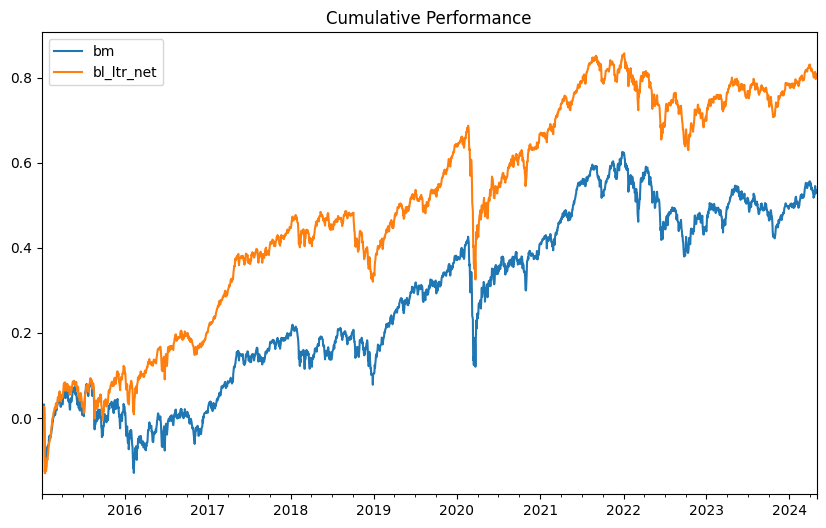

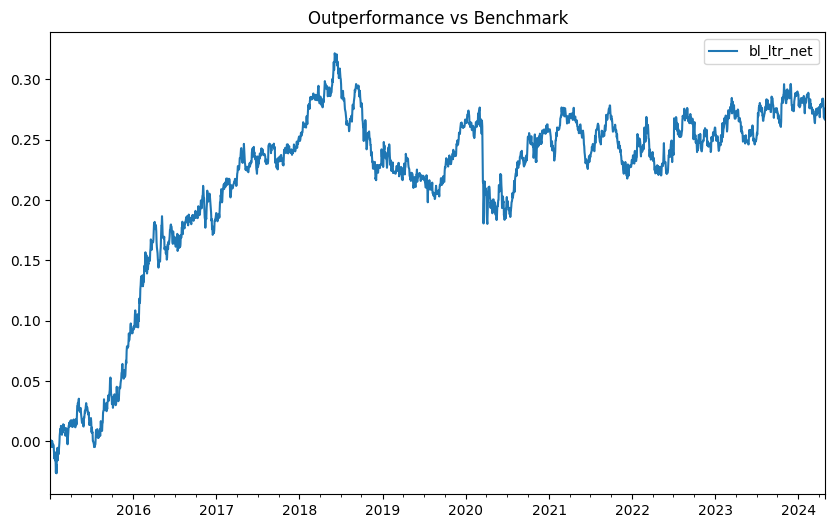

In [ ]:
# --------------------------------------------------------------------------
# Simulate strategies
# --------------------------------------------------------------------------

bt_bl_ltr = load_pickle(
    filename = 'backtest_bl_ltr.pickle',
    path = path,
)

#bt_sv_retrain_monthly = load_pickle(
#    filename = 'backtest_sv_retrain_monthly.pickle',
#    path = path,
#)

fixed_costs = 0
variable_costs = 0.002
return_series = bs.data.get_return_series()

strategy_dict = {
    'bl_ltr': bt_bl_ltr.strategy,
#    'sv_retrain_monthly': bt_sv_retrain_monthly.strategy,
}

sim_dict_gross = {
    f'{key}_gross': value.simulate(
        return_series=return_series,
        fc=fixed_costs,
        vc=0,
    )
    for key, value in strategy_dict.items()
}
sim_dict_net = {
    f'{key}_net': value.simulate(
        return_series=return_series,
        fc=fixed_costs,
        vc=variable_costs,
    )
    for key, value in strategy_dict.items()
}

# Flag: when True, scale the benchmark returns by the Net Exposure, to make the comparison fairer

# 1) fetch weights and calculate exposures
bm_weights_scale = False

# 1) fetch weights and calculate exposures
wts = bt_bl_ltr.strategy.get_weights_df()

# ensure the index is real datetime, not strings
wts.index    = pd.to_datetime(wts.index)

net_exposure = wts.sum(axis=1)
gross_exposure = wts.abs().sum(axis=1)
net_exposure.name   = "Net Exposure"
gross_exposure.name = "Gross Exposure"

# 2) build sim DataFrame with unscaled bm
sim = pd.concat({
    'bm': bs.data.bm_series,
    **sim_dict_net,
}, axis=1)

# 3) optionally scale bm in-place
if bm_weights_scale:
    # align net_exposure to sim’s index, fill any edge NaNs
    ne = net_exposure.reindex(sim.index).fillna(method='ffill').fillna(method='bfill')
    for col in sim.columns:
        sim[col] = sim[col] * ne

# 4) drop any remaining NaNs and plot
sim = sim.dropna()
#sim = sim.iloc[1:]  

cumulative_returns = np.log(1 + sim).cumsum()
cumulative_returns.plot(title='Cumulative Performance', figsize=(10, 6))

outperformance = cumulative_returns.subtract(cumulative_returns['bm'], axis=0)
outperformance.drop(columns=['bm'], errors='ignore').plot(
    title='Outperformance vs Benchmark', figsize=(10, 6)
)

Explain the code and describe and explain graphs

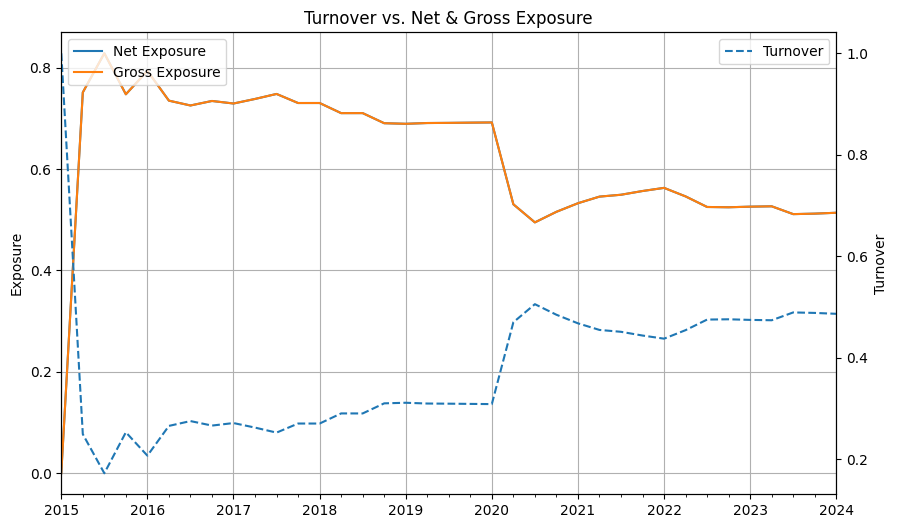

In [ ]:
# --------------------------------------------------------------------------
# Turnover
# --------------------------------------------------------------------------

# existing turnover & weights
to_bl_ltr = bt_bl_ltr.strategy.turnover(return_series=return_series)
to_bl_ltr.index    = pd.to_datetime(to_bl_ltr.index)

# name turnover
to_bl_ltr.name = "Turnover"

# combine into one DataFrame
df = pd.concat([to_bl_ltr, net_exposure, gross_exposure], axis=1).dropna()

# plot Net & Gross Exposure on primary axis, Turnover on secondary
ax = df[["Net Exposure","Gross Exposure"]].plot(title="Turnover vs. Net & Gross Exposure", figsize=(10,6))
ax.set_ylabel("Exposure")
ax.grid(True)

ax2 = ax.twinx()
df["Turnover"].plot(ax=ax2, linestyle="--", label="Turnover")
ax2.set_ylabel("Turnover")
ax2.legend(loc="upper right")

# show legend for exposures
ax.legend(loc="upper left")

Describe and explain graph

In [ ]:
# --------------------------------------------------------------------------
# Decriptive statistics
# --------------------------------------------------------------------------

# Alternative implementation without empyrical

# Helper functions for performance metrics
def annual_return(series, periods_per_year=252):
    return (1 + series.mean()) ** periods_per_year - 1

def cumulative_returns(series):
    return (1 + series).prod() - 1

def annual_volatility(series, periods_per_year=252):
    return series.std() * np.sqrt(periods_per_year)

def sharpe_ratio(series, risk_free_rate=0, periods_per_year=252):
    excess_return = series - risk_free_rate / periods_per_year
    return excess_return.mean() / series.std() * np.sqrt(periods_per_year)

def max_drawdown(series):
    cumulative = (1 + series).cumprod()
    drawdown = cumulative / cumulative.cummax() - 1
    return drawdown.min()


def tracking_error(series, benchmark):
    return (series - benchmark).std() * np.sqrt(252)

def downside_tracking_error(series, benchmark):
    active     = series - benchmark
    neg_active = active[active < 0]
    return np.sqrt(np.mean(neg_active**2)) * np.sqrt(252)

def information_ratio(series, benchmark):
    active = series - benchmark
    # annualized active return / annualized tracking error
    return (active.mean() * 252) / (active.std() * np.sqrt(252))


def capture_ratios(r_p: pd.Series, r_b: pd.Series) -> tuple[float,float]:
    """
    Calculate upside and downside capture of portfolio returns r_p vs. benchmark r_b.
    Returns (upside_capture, downside_capture).
    """
    up_ix   = r_b > 0
    down_ix = r_b < 0

    avg_p_up   = r_p[ up_ix].mean()
    avg_b_up   = r_b[ up_ix].mean()
    avg_p_down = r_p[down_ix].mean()
    avg_b_down = r_b[down_ix].mean()

    up_cap   = avg_p_up   / avg_b_up   if avg_b_up   else np.nan
    down_cap = avg_p_down / avg_b_down if avg_b_down else np.nan
    return up_cap, down_cap

# Helper function for hit ratio
def hit_ratio(series, benchmark):
    """
    Calculate the hit ratio: percentage of periods where the strategy outperforms the benchmark.
    """
    return (series > benchmark).mean()

# Compute individual performance metrics for each simulated strategy
annual_return_dict        = {}
cumulative_returns_dict   = {}
annual_volatility_dict    = {}
sharpe_ratio_dict         = {}
max_drawdown_dict         = {}
tracking_error_dict       = {}
downside_te_dict          = {}
information_ratio_dict    = {}
hit_ratio_dict            = {}  # New dictionary for hit ratio
up_capture_dict           = {}
down_capture_dict         = {}

for column in sim.columns:
    print(f'Performance metrics for {column}')
    # existing metrics
    annual_return_dict[column]      = annual_return(sim[column])
    cumulative_returns_dict[column] = cumulative_returns(sim[column])
    annual_volatility_dict[column]  = annual_volatility(sim[column])
    sharpe_ratio_dict[column]       = sharpe_ratio(sim[column])
    max_drawdown_dict[column]       = max_drawdown(sim[column])
    tracking_error_dict[column]     = tracking_error(sim[column], sim['bm'])
    downside_te_dict[column]        = downside_tracking_error(sim[column], sim['bm'])
    information_ratio_dict[column]  = information_ratio(sim[column], sim['bm'])
    hit_ratio_dict[column]          = hit_ratio(sim[column], sim['bm'])  # Calculate hit ratio
    
    # up/down capture (skip benchmark itself)
    if column != 'bm':
        up_cap, down_cap = capture_ratios(sim[column], sim['bm'])
        up_capture_dict[column]   = up_cap
        down_capture_dict[column] = down_cap

# Combine results into DataFrames
annual_returns     = pd.DataFrame(annual_return_dict,      index=['Annual Return'])
cumret             = pd.DataFrame(cumulative_returns_dict, index=['Cumulative Return'])
annual_volatility  = pd.DataFrame(annual_volatility_dict,  index=['Annual Volatility'])
sharpe             = pd.DataFrame(sharpe_ratio_dict,       index=['Sharpe Ratio'])
mdd                = pd.DataFrame(max_drawdown_dict,       index=['Max Drawdown'])
tracking_error     = pd.DataFrame(tracking_error_dict,     index=['Tracking Error'])
downside_te        = pd.DataFrame(downside_te_dict,        index=['Downside Tracking Error'])
info_ratio         = pd.DataFrame(information_ratio_dict,  index=['Information Ratio'])
hit_ratio_df       = pd.DataFrame(hit_ratio_dict,          index=['Hit Ratio'])  # New DataFrame for hit ratio
up_capture         = pd.DataFrame(up_capture_dict,         index=['Upside Capture'])
down_capture       = pd.DataFrame(down_capture_dict,       index=['Downside Capture'])

# Concatenate all metrics into a single DataFrame
performance_metrics = pd.concat([
    annual_returns,
    cumret,
    annual_volatility,
    sharpe,
    mdd,
    tracking_error,
    downside_te,
    info_ratio,
    hit_ratio_df,  # Add hit ratio here
    up_capture,
    down_capture
])

performance_metrics

Performance metrics for bm
Performance metrics for bl_ltr_net


C:\Users\angus\AppData\Local\Temp\ipykernel_21800\1628031270.py:38: RuntimeWarning: invalid value encountered in scalar divide
  return (active.mean() * 252) / (active.std() * np.sqrt(252))


,bm,bl_ltr_net
Annual Return,0.067898,0.096450
Cumulative Return,0.701100,1.241378
Annual Volatility,0.145660,0.129850
Sharpe Ratio,0.451055,0.709239
Max Drawdown,-0.263289,-0.303189
Tracking Error,0.000000,0.065327
Downside Tracking Error,NaN,0.067194
Information Ratio,NaN,0.404023
Hit Ratio,0.000000,0.499383
Upside Capture,NaN,0.796392


Describe and explain results

# Appendix A - helper functions(Optimization)

## A.1 MaxSharpe

```python
class MaxSharpe(Optimization):

    def __init__(self,
                 constraints: Optional[Constraints] = None,
                 covariance: Optional[Covariance] = None,
                 expected_return: Optional[ExpectedReturn] = None,
                 turnover_penalty: Optional[float] = None,
                 risk_aversion: float = 1.0,
                 iterations: int = 10, 
                 **kwargs) -> None:
        super().__init__(
            constraints=constraints,
            **kwargs,
        )
        self.covariance = Covariance() if covariance is None else covariance
        self.expected_return = ExpectedReturn() if expected_return is None else expected_return
        self.params['turnover_penalty'] = turnover_penalty
        self.params['risk_aversion'] = risk_aversion
        self.iterations = iterations

    def set_objective(self, optimization_data: OptimizationData) -> None:
        self.data = optimization_data
        X = optimization_data['return_series']
        self.cov = self.covariance.estimate(X=X, inplace=False)
        self.mu  = self.expected_return.estimate(X=X, inplace=False)
        self.objective = Objective(
            q = -1.0 * self.mu,
            P = 2.0 * self.cov,
        )
        self.base_P = copy.deepcopy(2.0 * self.cov)

    def solve(self) -> None:
        parent_solve = super(MaxSharpe, self).solve

        def _neg_sharpe(lam: float) -> float:
            # scale P and re-solve
            self.params['risk_aversion'] = lam
            self.objective.coefficients["P"] = self.base_P * lam
            parent_solve()
            w = np.array(list(self.results["weights"].values()))
            sr = (self.mu @ w) / np.sqrt(w @ self.cov @ w)
            return -sr

        # one-line search over [1e-2,1e2]
        res = minimize_scalar(
            _neg_sharpe,
            bounds=(1e-2, 1e2),
            method="bounded",
            options={"maxiter": self.iterations, "xatol": 1e-3}
        )

        # unpack results
        best_lambda = res.x
        best_sharpe = -res.fun
        # re-solve once at the optimum to populate weights
        self.objective.P = self.base_P * best_lambda
        parent_solve()
        print('best_lambda:', best_lambda)
        self.results = {
            "weights":       self.results["weights"],
            "best_sharpe":   best_sharpe,
            "risk_aversion": best_lambda,
            "status":        True,
        }
        return None
```
---

## A.2 BlackLittermanMS

```python
class BlackLittermanMS(Optimization):

    def __init__(self,
                 fields: list[str],
                 covariance: Optional[Covariance] = None,
                 risk_aversion: float = 1,
                 tau_psi: float = 1,
                 tau_omega: float = 1,
                 view_method: str = 'absolute',
                 scalefactor: int = 1,
                 iterations: int = 5,
                 **kwargs) -> None:
        super().__init__(
            fields=fields,
            risk_aversion=risk_aversion,
            tau_psi=tau_psi,
            tau_omega=tau_omega,
            view_method=view_method,
            scalefactor=scalefactor,
            **kwargs
        )
        self.covariance = Covariance() if covariance is None else covariance
        self.iterations = iterations
    def set_objective(self, optimization_data: OptimizationData) -> None:
        '''
        Sets the objective function for the optimization problem.
        
        Parameters:
        training_data: Training data which must contain 
            return series (to compute the covariances) and scores.
        '''
        self.data = optimization_data
        # Retrieve configuration parameters from the params attribute
        fields = self.params.get('fields')
        risk_aversion = self.params.get('risk_aversion')
        tau_psi = self.params.get('tau_psi')
        tau_omega = self.params.get('tau_omega')
        view_method = self.params.get('view_method')
        scalefactor = self.params.get('scalefactor')

        # Calculate the covariance matrix
        self.covariance.estimate(
            X=optimization_data['return_series'],
            inplace=True,
        )

        # Extract benchmark weights
        cap_weights = optimization_data['cap_weights']

        # # Alternatively, calculate minimum tracking error portfolio
        # optim = LeastSquares(
        #     constraints = self.constraints,
        #     solver_name = self.params.get('solver_name'),
        # )
        # optim.set_objective(optimization_data=optimization_data)
        # optim.solve()
        # cap_weights = pd.Series(optim.results['weights'])

        # Implied expected return of benchmark
        mu_implied = risk_aversion * self.covariance.matrix @ cap_weights

        # Extract scores
        scores = optimization_data['scores'][fields]

        # Construct the views
        P_tmp = {}
        q_tmp = {}
        for col in scores.columns:
            P_tmp[col], q_tmp[col] = generate_views_from_scores(
                scores=scores[col],
                mu_implied=mu_implied,
                method=view_method,
                scalefactor=scalefactor,
            )

        P = pd.concat(P_tmp, axis=0)
        q = pd.concat(q_tmp, axis=0)

        # Define the uncertainty of the views
        Omega = pd.DataFrame(
            np.diag([tau_omega] * len(q)),
            index=q.index,
            columns=q.index
        )
        Psi = self.covariance.matrix * tau_psi

        # Compute the posterior expected return vector
        mu_posterior = bl_posterior_mean(
            mu_prior=mu_implied,
            P=P,
            q=q,
            Psi=Psi,
            Omega=Omega,
        )
        
        self.mu = copy.deepcopy(mu_posterior)
        self.cov = copy.deepcopy(self.covariance.matrix)

        self.objective = Objective(
            q = mu_posterior * (-1),
            P = self.covariance.matrix * risk_aversion * 2,
            mu_implied = mu_implied,
            mu_posterior = mu_posterior,
        )


    def solve(self) -> None:
        parent_solve = super(BlackLittermanMS, self).solve

        def _neg_sharpe(lam: float) -> float:
            # scale P and re-solve
            self.params['risk_aversion'] = lam
            self.set_objective(optimization_data=self.data)
            parent_solve()
            w = np.array(list(self.results["weights"].values()))
            sr = (self.mu @ w) / np.sqrt(w @ self.cov @ w)
            return -sr

        # one-line search over [1e-2,1e2]
        res = minimize_scalar(
            _neg_sharpe,
            bounds=(1e-2, 1e2),
            method="bounded",
            options={"maxiter": self.iterations, "xatol": 1e-3}
        )

        # unpack results
        best_lambda = res.x
        best_sharpe = -res.fun
        # re-solve once at the optimum to populate weights
        self.params['risk_aversion'] = best_lambda
        self.set_objective(optimization_data=self.data)
        parent_solve()
        print('best_lambda:', best_lambda)
        self.results = {
            "weights":       self.results["weights"],
            "best_sharpe":   best_sharpe,
            "risk_aversion": best_lambda,
            "status":        True,
        }
        return None
```

# Appendix B - helper functions(Item builder functions)

## B.1 bibfn_equal_weights

```python
def bibfn_equal_weights(bs: 'BacktestService', rebdate: str, **kwargs) -> None:

    # Selection
    ids = bs.selection.selected

    # Data - market capitalization
    mcap = bs.data.market_data['mktcap']

    # Get last available values for current rebdate
    mcap = mcap[mcap.index.get_level_values('date') <= rebdate].groupby(
        level = 'id'
    ).last()

    # Remove duplicates
    mcap = mcap[~mcap.index.duplicated(keep=False)].loc[ids]
    
    # Attach cap-weights to the optimization data object
    bs.optimization_data['cap_weights'] = (0*mcap+1)/ len(mcap)

    return None
```

---

## B.2 bibfn_sector_exposure_constraints

```python

def bibfn_sector_exposure_constraints(
    bs: 'BacktestService',
    rebdate: str,
    limits: dict = None,
    default_limit: float = 0.2,
    sector_field: str = 'sector', **kwargs
) -> None:
    """
    Backtest item builder that adds linear constraints on sector weights:
    sum of weights for each sector <= specified limit.

    Args:
        bs: BacktestService
        rebdate: rebalance date
        limits: dict mapping sector name to maximum weight (e.g. {'Tech':0.2, 'Health':0.15});
                if None, uses kwargs defaults or a uniform limit of 0.2
        sector_field: name of sector column in bs.data.market_data
    """
    # Load sector data
    sd = bs.data.market_data[sector_field]
    # get last available sector per id up to rebalance date
    sd = sd[sd.index.get_level_values('date') <= rebdate]
    last_sector = sd.groupby(level='id').last()

    # Determine unique sectors
    sectors = last_sector.unique()

    # Default uniform limit if none provided
    if limits is None:
        # uniform 20% per sector
        limits = {s: default_limit for s in sectors}

    # Build G matrix: one row per sector
    ids = bs.optimization.constraints.ids
    # Initialize DataFrame for G and RHS
    G_rows = []
    sense = []
    rhs = []
    names = []
    for sector, lim in limits.items():
        # indicator 1 for ids in this sector, else 0
        mask = (last_sector.reindex(ids).fillna('') == sector).astype(int)
        # skip if no ids in this sector
        if mask.sum() == 0:
            continue
        G_rows.append(mask.values)
        sense.append('<=')
        rhs.append(lim)
        names.append(f"sect_{sector}")

    # create DataFrame G with index names and columns ids
    G = pd.DataFrame(G_rows, index=names, columns=ids)
    rhs = pd.Series(rhs, index=names)
    # Add linear constraints
    bs.optimization.constraints.add_linear(G=G, sense=sense, rhs=rhs)
    return None
```

